# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

# Rozwiązanie

In [3]:
from copy import deepcopy
from copy import copy
import random
import math
EPSILON = 1e-9

In [31]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def to_tuple():
        return (self.x, self.y)

def new_point(point, xadd = 0, yadd = 0):
    return Point(point.x+xadd, point.y+yadd)


 
class QTNode:
    def __init__(self, all_points, lower_left, width, height, points, k):
        self.lower_left = lower_left
        self.width = width
        self.height = height
        self.k = k
        self.points = points
        self.all_points = all_points
        self.children = []
        self.lines = []

    def seek_points(self, lower_left, width, height):
        result = []
        for point in self.points:
            if lower_left.x <= point.x <= lower_left.x + width and lower_left.y <= point.y <= lower_left.y + height:
                result.append(point)
        return result
    
    def divide_node(self, sc):
        
        if len(self.points) > self.k:
            new_width = self.width / 2
            new_height = self.height / 2
            lines =[]
            ll = new_point(self.lower_left) # lower left
            points = self.seek_points(ll, new_width, new_height)
            lower_left_branch = QTNode(self.all_points, ll, new_width, new_height, points, self.k)
            
#             lines.append(((ll.x, ll.y), (ll.x+ new_width, ll.y)))
#             lines.append(((ll.x, ll.y), (ll.x, ll.y+new_height)))
#             lines.append(((ll.x+new_width, ll.y), (ll.x+ new_width, ll.y+new_height)))
#             lines.append(((ll.x, ll.y+new_height), (ll.x+ new_width, ll.y+new_height)))
            all_lines.append(((ll.x, ll.y), (ll.x+ new_width, ll.y)))
            all_lines.append(((ll.x, ll.y), (ll.x, ll.y+new_height)))
            all_lines.append(((ll.x+new_width, ll.y), (ll.x+ new_width, ll.y+new_height)))
            all_lines.append(((ll.x, ll.y+new_height), (ll.x+ new_width, ll.y+new_height)))
            self.lines.append(((ll.x, ll.y), (ll.x+ new_width, ll.y)))
            self.lines.append(((ll.x, ll.y), (ll.x, ll.y+new_height)))
            self.lines.append(((ll.x+new_width, ll.y), (ll.x+ new_width, ll.y+new_height)))
            self.lines.append(((ll.x, ll.y+new_height), (ll.x+ new_width, ll.y+new_height)))
                         
            sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.all_points],color='black'),
                                 PointsCollection([(point.x, point.y) for point in self.points],color='lightblue'), 
                                 PointsCollection([(point.x, point.y) for point in points],color='red')],
                               [LinesCollection(lines.copy(), color='black'),
                                LinesCollection(all_lines.copy(), color='orange')]))
            
            lower_left_branch.divide_node(sc)
            
            lr = new_point(self.lower_left, new_width, 0) # lower right
            points = self.seek_points(lr, new_width, new_height)
            lower_right_branch = QTNode(self.all_points, lr, new_width, new_height, points, self.k)
            
#             lines.append(((lr.x, lr.y), (lr.x+ new_width, lr.y)))
#             lines.append(((lr.x, lr.y), (lr.x, lr.y+new_height)))
#             lines.append(((lr.x+new_width, lr.y), (lr.x+ new_width, lr.y+new_height)))
#             lines.append(((lr.x, lr.y+new_height), (lr.x+ new_width, lr.y+new_height)))
            all_lines.append(((lr.x, lr.y), (lr.x+ new_width, lr.y)))
            all_lines.append(((lr.x, lr.y), (lr.x, lr.y+new_height)))
            all_lines.append(((lr.x+new_width, lr.y), (lr.x+ new_width, lr.y+new_height)))
            all_lines.append(((lr.x, lr.y+new_height), (lr.x+ new_width, lr.y+new_height)))
            self.lines.append(((lr.x, lr.y), (lr.x+ new_width, lr.y)))
            self.lines.append(((lr.x, lr.y), (lr.x, lr.y+new_height)))
            self.lines.append(((lr.x+new_width, lr.y), (lr.x+ new_width, lr.y+new_height)))
            self.lines.append(((lr.x, lr.y+new_height), (lr.x+ new_width, lr.y+new_height)))
            
            sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.all_points],color='black'),
                                 PointsCollection([(point.x, point.y) for point in self.points],color='lightblue'), 
                                 PointsCollection([(point.x, point.y) for point in points],color='red')],
                               [LinesCollection(lines, color='black'),
                                LinesCollection(all_lines.copy(), color='olive')]))
            
            lower_right_branch.divide_node(sc)
            
            ul = new_point(self.lower_left, 0, new_height) # upper left
            points = self.seek_points(ul, new_width, new_height)
            upper_left_branch = QTNode(self.all_points, ul, new_width, new_height, points, self.k)
            
#             lines.append(((ul.x, ul.y), (ul.x+ new_width, ul.y)))
#             lines.append(((ul.x, ul.y), (ul.x, ul.y+new_height)))
#             lines.append(((ul.x+new_width, ul.y), (ul.x+ new_width, ul.y+new_height)))
#             lines.append(((ul.x, ul.y+new_height), (ul.x+ new_width, ul.y+new_height)))
            all_lines.append(((ul.x, ul.y), (ul.x+ new_width, ul.y)))
            all_lines.append(((ul.x, ul.y), (ul.x, ul.y+new_height)))
            all_lines.append(((ul.x+new_width, ul.y), (ul.x+ new_width, ul.y+new_height)))
            all_lines.append(((ul.x, ul.y+new_height), (ul.x+ new_width, ul.y+new_height)))
            self.lines.append(((ul.x, ul.y), (ul.x+ new_width, ul.y)))
            self.lines.append(((ul.x, ul.y), (ul.x, ul.y+new_height)))
            self.lines.append(((ul.x+new_width, ul.y), (ul.x+ new_width, ul.y+new_height)))
            self.lines.append(((ul.x, ul.y+new_height), (ul.x+ new_width, ul.y+new_height)))
            
            sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.all_points],color='black'),
                                 PointsCollection([(point.x, point.y) for point in self.points],color='lightblue'), 
                                 PointsCollection([(point.x, point.y) for point in points],color='red')],
                               [LinesCollection(lines, color='black'),
                                LinesCollection(all_lines.copy(), color='pink')]))
            
            upper_left_branch.divide_node(sc)
            
            ur = new_point(self.lower_left, new_width, new_height) # upper right
            points = self.seek_points(ur, new_width, new_height)
            upper_right_branch = QTNode(self.all_points, ur, new_width, new_height, points, self.k)
            
#             lines.append(((ur.x, ur.y), (ur.x+ new_width, ur.y)))
#             lines.append(((ur.x, ur.y), (ur.x, ur.y+new_height)))
#             lines.append(((ur.x+new_width, ur.y), (ur.x+ new_width, ur.y+new_height)))
#             lines.append(((ur.x, ur.y+new_height), (ur.x+ new_width, ur.y+new_height)))
            all_lines.append(((ur.x, ur.y), (ur.x+ new_width, ur.y)))
            all_lines.append(((ur.x, ur.y), (ur.x, ur.y+new_height)))
            all_lines.append(((ur.x+new_width, ur.y), (ur.x+ new_width, ur.y+new_height)))
            all_lines.append(((ur.x, ur.y+new_height), (ur.x+ new_width, ur.y+new_height)))
            self.lines.append(((ur.x, ur.y), (ur.x+ new_width, ur.y)))
            self.lines.append(((ur.x, ur.y), (ur.x, ur.y+new_height)))
            self.lines.append(((ur.x+new_width, ur.y), (ur.x+ new_width, ur.y+new_height)))
            self.lines.append(((ur.x, ur.y+new_height), (ur.x+ new_width, ur.y+new_height)))
            
            sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.all_points],color='black'),
                                 PointsCollection([(point.x, point.y) for point in self.points],color='lightblue'), 
                                 PointsCollection([(point.x, point.y) for point in points],color='red')],
                                [LinesCollection(lines, color='black'),
                                LinesCollection(all_lines.copy(), color='cyan')]))
            
            upper_right_branch.divide_node(sc)
            
            self.children = [lower_left_branch, lower_right_branch, 
                             upper_left_branch, upper_right_branch]
            
            sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.all_points],color='black'),
                                 PointsCollection([(point.x, point.y) for point in self.points],color='lightblue'), 
                                 PointsCollection([(point.x, point.y) for point in points],color='red')],
                                [LinesCollection(lines, color='black'),
                                LinesCollection(all_lines.copy(), color='blue')]))

                
    def find(self, rec_lower_left, rec_upper_right, result, sc):
        lines = (((self.lower_left.x, self.lower_left.y),(self.lower_left.x+self.width, self.lower_left.y)),
                ((self.lower_left.x, self.lower_left.y),(self.lower_left.x, self.lower_left.y+self.height)),
                ((self.lower_left.x+self.width, self.lower_left.y),(self.lower_left.x+self.width, self.lower_left.y+self.height)),
                ((self.lower_left.x, self.lower_left.y+self.height),(self.lower_left.x+self.width, self.lower_left.y+self.height)))
        sc.append(Scene([PointsCollection([(p.x, p.y) for p in self.all_points],color='black'),
                                 PointsCollection([(p.x, p.y) for p in self.points],color='lightblue'), 
                                 PointsCollection([(p.x, p.y) for p in result.copy()],color='red')],
                                         [LinesCollection(all_lines.copy(), color='blue'),
                                          LinesCollection(lines,color='red'),
                                          LinesCollection([((rec_lower_left.x, rec_lower_left.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_lower_left.x, rec_lower_left.y), (rec_lower_left.x, rec_upper_right.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_lower_left.x, rec_upper_right.y))], 
                                     color='darkred')]))
        if len(self.children) == 0: # jest dzieckiem
            for point in self.points:
                if rec_lower_left.x <= point.x <= rec_upper_right.x and rec_lower_left.y <= point.y <= rec_upper_right.y:
                    result.append(point)
            sc.append(Scene([PointsCollection([(p.x, p.y) for p in self.all_points],color='black'),
                                 PointsCollection([(p.x, p.y) for p in self.points],color='lightblue'), 
                                 PointsCollection([(p.x, p.y) for p in result.copy()],color='red')],
                                         [LinesCollection(all_lines.copy(), color='blue'),
                                          LinesCollection(lines,color='green'),
                                          LinesCollection([((rec_lower_left.x, rec_lower_left.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_lower_left.x, rec_lower_left.y), (rec_lower_left.x, rec_upper_right.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_lower_left.x, rec_upper_right.y))], 
                                     color='darkred')]))
            return result
        
        if self.lower_left.x >= rec_lower_left.x and self.lower_left.x + self.width <= rec_upper_right.x \
        and self.lower_left.y >= rec_lower_left.y and self.lower_left.y + self.height <= rec_upper_right.y: # zawiera się w x zawiera się w y
            for point in self.points:
                result.append(point)
                sc.append(Scene([PointsCollection([(p.x, p.y) for p in self.all_points],color='black'),
                                 PointsCollection([(p.x, p.y) for p in self.points],color='lightblue'), 
                                 PointsCollection([(p.x, p.y) for p in result.copy()],color='red')],
                                     [LinesCollection(all_lines.copy(), color='blue'),
                                      LinesCollection(lines,color='olive'),
                                      LinesCollection([((rec_lower_left.x, rec_lower_left.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_lower_left.x, rec_lower_left.y), (rec_lower_left.x, rec_upper_right.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_lower_left.x, rec_upper_right.y))], 
                                     color='darkred')]))
                                     
            return result
        
        if self.lower_left.x > rec_upper_right.x or self.lower_left.x + self.width < rec_lower_left.x \
        or self.lower_left.y > rec_upper_right.y or self.lower_left.y + self.height < rec_lower_left.y:
            return result
        
        for child in self.children: # sprawdź dzieci
            child.find(rec_lower_left, rec_upper_right, result, sc)
        return result
        
                    
class QuadTree:
    def __init__(self, points, k):
        self.left = min(points, key=lambda point: point.x) 
        self.right = max(points, key=lambda point: point.x)
        self.down = min(points, key=lambda point: point.y)
        self.up = max(points, key=lambda point: point.y) 
        self.lower_left = Point(self.left.x - EPSILON, self.down.y - EPSILON)
        self.width = self.right.x - self.left.x + 2* EPSILON
        self.height = self.up.y - self.down.y + 2* EPSILON
        self.points = points
        self.k = k
        self.sc = []
        self.sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.points],color='lightblue')]))
        self.root = QTNode(self.points, self.lower_left, self.width, self.height, self.points, k)
        self.root.divide_node(self.sc)
        self.sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.points],color='black')],
                            [LinesCollection(all_lines.copy(), color='blue')]))
    
    def find_points(self, rec_lower_left, rec_upper_right):
        result = []
        sc = []
        self.root.find(rec_lower_left, rec_upper_right, result, sc)
        sc.append(Scene([PointsCollection([(point.x, point.y) for point in self.points],color='black'),
                     PointsCollection([(point.x, point.y) for point in result],color='red')],
                    [LinesCollection(all_lines.copy(), color='blue'),
                     LinesCollection([((rec_lower_left.x, rec_lower_left.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_lower_left.x, rec_lower_left.y), (rec_lower_left.x, rec_upper_right.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_upper_right.x, rec_lower_left.y)),
                                      ((rec_upper_right.x, rec_upper_right.y), (rec_lower_left.x, rec_upper_right.y))], 
                                     color='red')]))
        return result, sc
            
            

In [47]:
inputt = []
for i in range(20):
    x = np.random.uniform(0,10)
    y = np.random.uniform(0,10)
    inputt.append(Point(x, y))

In [48]:
def generic_square_diagonal(nside, ndiagonal, ll, ru):
    arr = [ll, Point(ll.x, ru.y), Point(ru.x, ll.y), ru]
    for _ in range(nside):
        arr.append(Point(ll.x, random.uniform(ll.y,ru.y)))
        arr.append(Point(random.uniform(ll.x, ru.x), ll.y))
    for _ in range(ndiagonal):
        x = random.uniform(ll.x, ru.x)
        arr.append(Point(x, x))
        arr.append(Point(x, ru.y-x))
    return arr

In [49]:
square = generic_square_diagonal(25, 20, Point(0.0, 0.0), Point(10.0, 10.0))

# Jak tego używać

QuadTree przyjmuje 2 parametry (tablicę obiektów typu Points, maksymalną liczbę punktów w liściu) <br>
rec_lower_left to lewy dolny wierzchołek prostokąta w którym szukamy punktów,, analogicznie rec_upper_right<br>
funkcja find_points odpowiada za znajdowanie punktów w zadanym prostokącie i zwraca tablicę Points z punktami i sc<br>
QT.sc to sceny budowania <br>
sc to sceny wyszukiwania<br>

In [54]:
all_lines = [] 
QT = QuadTree(inputt, 4)
rec_lower_left = Point(0.0,0.0)
rec_upper_right = Point(7.0,7.0)
found, sc = QT.find_points(rec_lower_left, rec_upper_right)

<IPython.core.display.Javascript object>


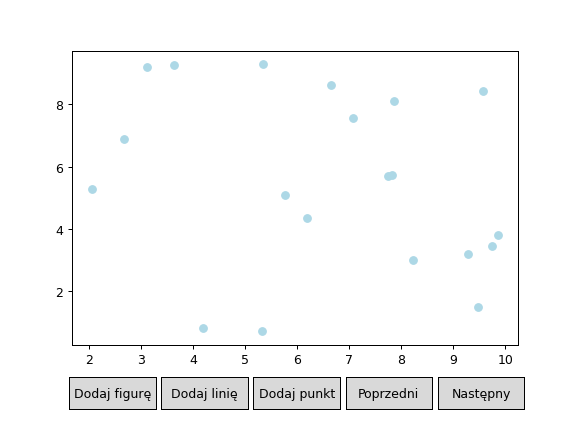

In [55]:
%matplotlib notebook
plot = Plot(scenes=QT.sc)
plot.draw()

<IPython.core.display.Javascript object>


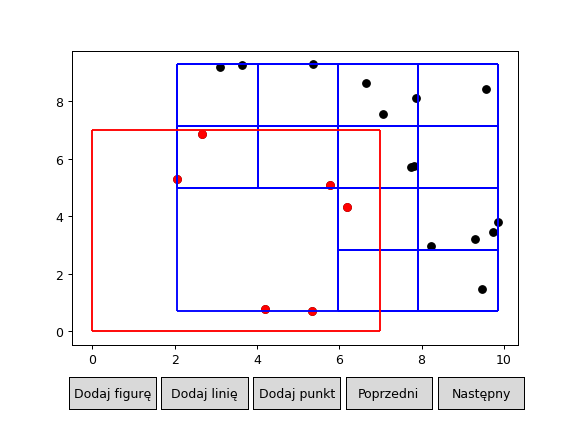

In [56]:
%matplotlib notebook
plot = Plot(scenes=sc)
plot.draw()

# Quad Tree Raw

In [11]:
class QTNode:
    def __init__(self, all_points, lower_left, width, height, points, k):
        self.lower_left = lower_left
        self.width = width
        self.height = height
        self.points = points
        self.all_points = all_points
        self.children = []
        self.lines = []
        self.k = k

    def seek_points(self, lower_left, width, height):
        result = []
        for point in self.points:
            if lower_left.x <= point.x <= lower_left.x + width and lower_left.y <= point.y <= lower_left.y + height:
                result.append(point)
        return result
    
    def divide_node(self):
        
        if len(self.points) > MAX_POINTS:
            new_width = self.width / 2
            new_height = self.height / 2
            lines =[]
            ll = new_point(self.lower_left) # lower left
            points = self.seek_points(ll, new_width, new_height)
            lower_left_branch = QTNode(self.all_points, ll, new_width, new_height, points, self.k)
            
            lower_left_branch.divide_node()
            
            lr = new_point(self.lower_left, new_width, 0) # lower right
            points = self.seek_points(lr, new_width, new_height)
            lower_right_branch = QTNode(self.all_points, lr, new_width, new_height, points, self.k)
            
            lower_right_branch.divide_node()
            
            ul = new_point(self.lower_left, 0, new_height) # upper left
            points = self.seek_points(ul, new_width, new_height)
            upper_left_branch = QTNode(self.all_points, ul, new_width, new_height, points, self.k)
            
            upper_left_branch.divide_node()
            
            ur = new_point(self.lower_left, new_width, new_height) # upper right
            points = self.seek_points(ur, new_width, new_height)
            upper_right_branch = QTNode(self.all_points, ur, new_width, new_height, points, self.k)
            
            upper_right_branch.divide_node()
            
            self.children = [lower_left_branch, lower_right_branch, 
                             upper_left_branch, upper_right_branch]
            
                
    def find(self, rec_lower_left, rec_upper_right, result):
        if len(self.children) == 0: # jest dzieckiem
            for point in self.points:
                if rec_lower_left.x <= point.x <= rec_upper_right.x and rec_lower_left.y <= point.y <= rec_upper_right.y:
                    result.append(point)
            return result
        
        if self.lower_left.x >= rec_lower_left.x and self.lower_left.x + self.width <= rec_upper_right.x \
        and self.lower_left.y >= rec_lower_left.y and self.lower_left.y + self.height <= rec_upper_right.y: # zawiera się w x zawiera się w y
            for point in self.points:
                result.append(point)  
            return result
        
        if self.lower_left.x > rec_upper_right.x or self.lower_left.x + self.width < rec_lower_left.x \
        or self.lower_left.y > rec_upper_right.y or self.lower_left.y + self.height < rec_lower_left.y:
            return result
        
        for child in self.children: # sprawdź dzieci
            child.find(rec_lower_left, rec_upper_right, result)
        return result
        
                    
class QuadTree:
    def __init__(self, points, k):
        self.left = min(points, key=lambda point: point.x) 
        self.right = max(points, key=lambda point: point.x)
        self.down = min(points, key=lambda point: point.y)
        self.up = max(points, key=lambda point: point.y) 
        self.lower_left = Point(self.left.x - EPSILON, self.down.y - EPSILON)
        self.width = self.right.x - self.left.x + 2* EPSILON
        self.height = self.up.y - self.down.y + 2* EPSILON
        self.points = points
        self.k = k
        self.root = QTNode(self.points, self.lower_left, self.width, self.height, self.points, self.k)
        self.root.divide_node()

    
    def find_points(self, rec_lower_left, rec_upper_right):
        result = []
        self.root.find(rec_lower_left, rec_upper_right, result)
        return result
            
            